In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,precision_score
from explainerdashboard import ClassifierExplainer, ExplainerDashboard
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
#plt.style.use('ggplot')

%matplotlib inline
matplotlib.rcParams['figure.figsize']=(15,10)


The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`

The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`

The dash_table package is deprecated. Please replace
`import dash_table` with `from dash import dash_table`

Also, if you're using any of the table format helpers (e.g. Group), replace 
`from dash_table.Format import Group` with 
`from dash.dash_table.Format import Group`


In [2]:
feature_descriptions={'State':'Customer’s state',
'Account Length':'Integer number showing the duration of activity for customer account',
'Area Code':'Area code of customer',
'Phone':'Phone number of customer',
"Int'l Plan":'Binary indicator showing whether the customer has international calling plan',
'VMail Plan':'Indicator of voice mail plan',
'VMail Message':'The number of voicemail messages',
'Day Mins':'The number of minutes the customer used the service during day time',
'Day Calls':'Discrete attribute indicating the total number of calls during day time',
'Day Charge':'Charges for using the service during day time',
'Eve Mins':'The number of minutes the customer used the service during evening time',
'Eve Calls':' The number of calls during evening time',
'Eve Charge':' Charges for using the service during evening time',
'Night Mins':' Number of minutes the customer used the service during night time',
'Night Calls':'The number of calls during night time',
'Night Charge':'Charges for using the service during night time',
'Intl Mins':'Number of minutes the customer used the service to make international calls',
'Intl Calls':'The number of international calls',
'Intl Charge':'Charges for international calls',
'CustServ Calls':'The number of calls to customer support service'
}

# Import dataset

In [3]:
df=pd.read_csv('churn.csv')

In [4]:
df.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


# Analysis using all original data including area code and phone number

In [5]:
df_all=df.copy()
df_all['Phone']=df_all['Phone'].apply(lambda p:int(p[:3]+p[4:]))
df_all["Int'l Plan"]=df_all["Int'l Plan"].apply(lambda i:0 if i=="no" else 1)
df_all['VMail Plan']=df_all['VMail Plan'].apply(lambda v:0 if v=='no' else 1)
df_all['Churn?']=df_all['Churn?'].apply(lambda c:0 if c=='False.' else 1)

### Building a heatmap showing correlationship for all columns (Except State)

Text(0.5, 1.0, 'Correlation Matric for all features (Except State)')

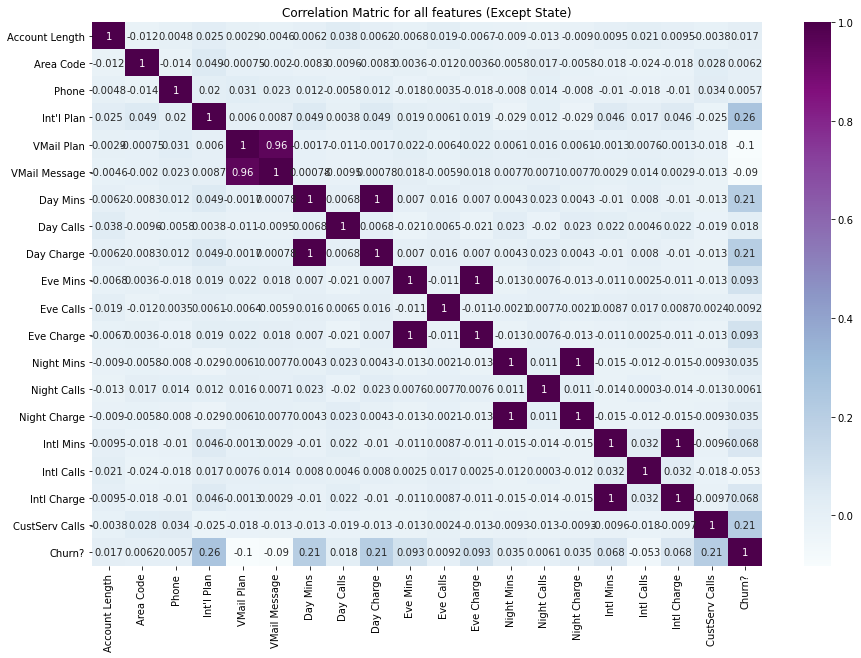

In [6]:
sns.heatmap(df_all.corr(),annot=True,cmap='BuPu')
plt.title('Correlation Matric for all features (Except State)')

In [7]:
X_all=df_all.iloc[:,:-1]
y_all=df_all.iloc[:,-1]

In [8]:
X_all=pd.get_dummies(X_all,columns=['State'])

In [9]:
X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(X_all, y_all, test_size = 0.4, random_state = 0)

### Scaling data (Because phone number is a million-level number and others are only hundred-level)

In [10]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_all_train.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]=sc.fit_transform(X_all_train.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18]])
X_all_test.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]=sc.transform(X_all_test.iloc[:,[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16,17,18]])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
X_all_train.head()

,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
3022,0.554325,-0.522083,0.318263,0,1,1.798934,-0.603426,-0.664111,-0.603696,-1.708606,...,0,0,0,0,0,0,0,0,0,0
442,-1.033133,1.718307,-1.113305,0,1,1.507967,-0.850400,0.688342,-0.850132,0.386215,...,0,0,0,0,0,0,0,0,0,0
1364,0.355892,-0.522083,-1.281654,0,0,-0.601549,1.196743,-0.163202,1.196687,0.967016,...,0,0,0,0,0,0,0,0,0,0
3038,0.504717,1.718307,-1.276293,0,1,1.435225,-1.273001,-0.313475,-1.273055,-1.182932,...,0,0,0,0,1,0,0,0,0,0
157,0.951189,1.718307,-1.666815,0,1,1.071515,-0.402188,1.439704,-0.402458,0.894170,...,0,0,0,0,1,0,0,0,0,0


In [12]:
def cm_scores(classifier,X_test,y_test):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test, y_pred),3)
    recall=round(recall_score(y_test,y_pred),3)
    precision=round(precision_score(y_test,y_pred),3)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))
    return tn,fp,fn,tp,accuracy,recall,precision

In [13]:
def get_importance(importance):
    import_df=pd.DataFrame(importance,index=X.columns)
    state_importance=0
    new_import_df=import_df.copy()
    for i in import_df.index.tolist():
        if 'State' in i:
            state_importance+=import_df[0][i]
            new_import_df=new_import_df.drop(i,axis=0)
    new_import_df=new_import_df.append(pd.DataFrame([state_importance],index=['State']))
    new_import_df=new_import_df.sort_values(by=0,ascending=False)
    ind=new_import_df.index.tolist()
    return ind,new_import_df

### Building Desicion Tree model for all columns

In [14]:
dtc_all = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dtc_all.fit(X_all_train,y_all_train)

DecisionTreeClassifier(criterion='entropy', random_state=0)

In [15]:
importance_dtc_all=dtc_all.feature_importances_

In [16]:
import_dtc_all=pd.DataFrame(importance_dtc_all,index=X_all.columns)
state_importance_dtc_all=0
new_import_dtc_all=import_dtc_all.copy()
for i in import_dtc_all.index.tolist():
    if 'State' in i:
        state_importance_dtc_all+=import_dtc_all[0][i]
        new_import_dtc_all=new_import_dtc_all.drop(i,axis=0)
new_import_dtc_all=new_import_dtc_all.append(pd.DataFrame([state_importance_dtc_all],index=['State']))
new_import_dtc_all=new_import_dtc_all.sort_values(by=0,ascending=False)
ind_dtc_all=new_import_dtc_all.index.tolist()

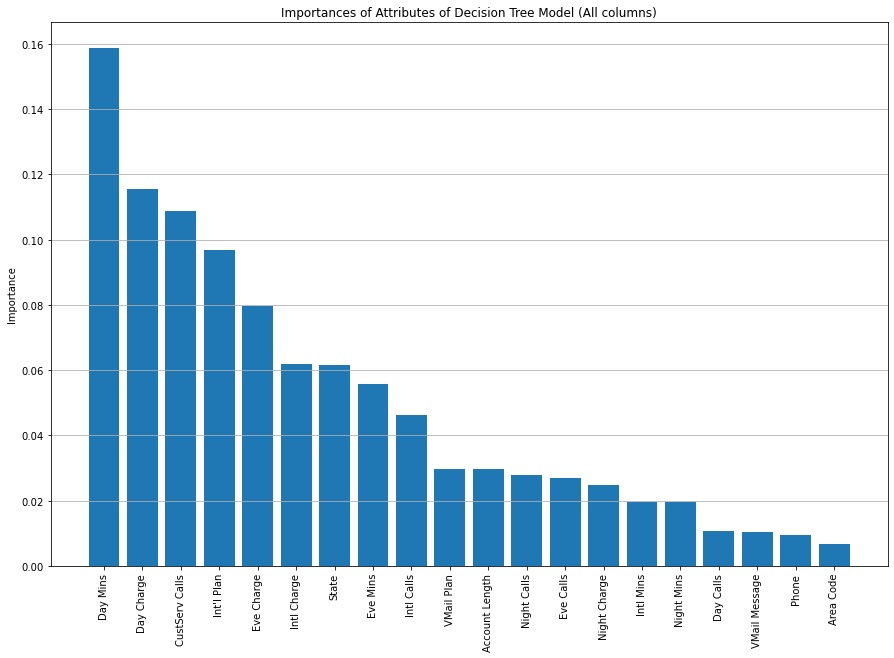

In [17]:
plt.bar([x for x in range(len(new_import_dtc_all))], new_import_dtc_all[0])
plt.xticks([i for i in range(len(ind_dtc_all))],ind_dtc_all,rotation=90)
plt.ylabel('Importance')
plt.title('Importances of Attributes of Decision Tree Model (All columns)')
plt.grid(axis='y')
plt.show()

# <font color='red'>Both heatmap and this bar chart shows that both "Phone" and "Area Code" are least meaningful to the class (less than 0.007 correlation in heatmap and less than 0.01 importance to the class). It will be probably overfitting if the 2 features included in the models).</font>

# Data Transformation

### Transform phone and binary attributes

In [18]:
df['Phone_Number']='('+df['Area Code'].astype('str')+')'+df['Phone']
df["Int'l Plan"]=df["Int'l Plan"].apply(lambda i:0 if i=="no" else 1)
df['VMail Plan']=df['VMail Plan'].apply(lambda i:0 if i=="no" else 1)
df['Churn?']=df['Churn?'].apply(lambda c:0 if c=="False." else 1)

In [19]:
df.index=df['Phone_Number']
df=df.drop(columns=['Area Code','Phone','Phone_Number'])

### Divide into attributes and class

In [20]:
X=df.iloc[:,:-1]
y=df.iloc[:,-1]

### Encoding State column

In [21]:
X=pd.get_dummies(X,columns=['State'])

### Splitting the dataset into the Training set and Test set

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [23]:
phone_numbers=X_test.index.tolist()

# Building model using Decision Tree

### Training the Decision Tree Classification model on the Training set

In [24]:
def decision_tree_class():
    classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    classifier.fit(X_train, y_train)
    return classifier

In [25]:
dt_class=decision_tree_class()

In [26]:
def generate_dt_dashboard():
    explainer_dt_all = ClassifierExplainer(dt_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_dt_all=ExplainerDashboard(explainer_dt_all, 
                            title="Churn Prediction by Decision Tree", 
                            shap_interaction=False,
                            )
    db_dt_all.run(port=8050)

### Making the Confusion Matrix for Decision Tree

In [27]:
dt_tn,dt_fp,dt_fn,dt_tp,dt_accuracy,dt_recall,dt_precision=cm_scores(dt_class,X_test,y_test)

[[797  65]
 [ 32 106]]
 
True Positive is 106.
True Negative is 797.
False Positive is 65.
False Negative is 32.

Accuracy is 0.903.
Recall is 0.768.
Precision is 0.62.



### Visualize the importances of attributes

In [28]:
importance_dt=dt_class.feature_importances_

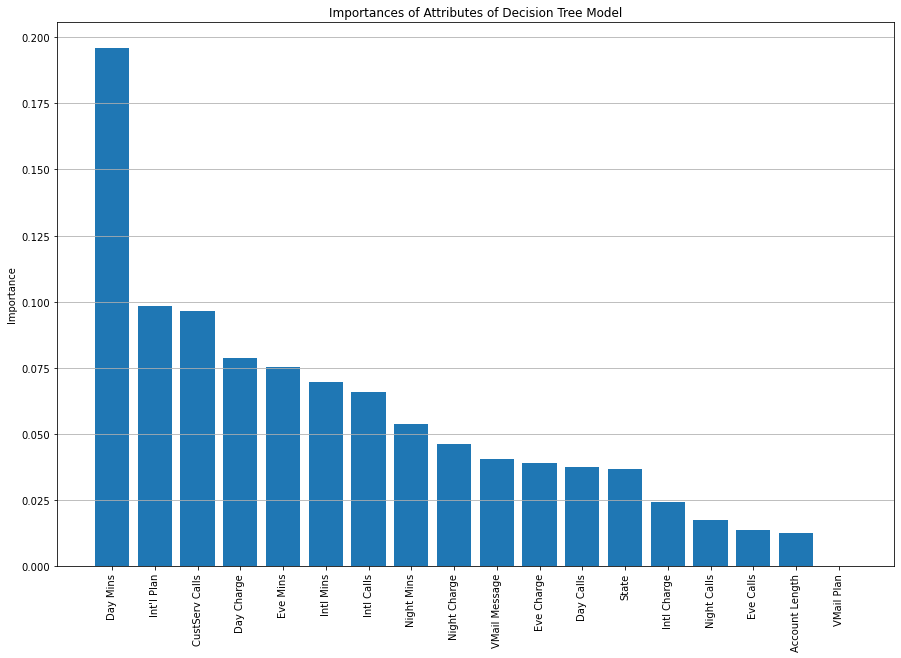

In [29]:
ind_dt,new_import_df_dt=get_importance(importance_dt)
plt.bar([x for x in range(len(new_import_df_dt))], new_import_df_dt[0])
plt.xticks([i for i in range(len(ind_dt))],ind_dt,rotation=90)
plt.ylabel('Importance')
plt.title('Importances of Attributes of Decision Tree Model')
plt.grid(axis='y')
plt.show()

# Building model using Naive Bayes

### Training the Naive Bayes Classification model on the Training set

In [30]:
def naive_bayes_class():
    classifier = GaussianNB()
    classifier.fit(X_train, y_train)
    return classifier

In [31]:
nb_class=naive_bayes_class()

In [32]:
def generate_nb_dashboard():
    explainer_nb_all = ClassifierExplainer(nb_class, X_test, y_test, 
                                    descriptions=feature_descriptions,
                                    labels=['Not Churn', 'Churn'], 
                                    cats=['State'],
                                    idxs = phone_numbers, 
                                    index_name = "Phone Number", 
                                    target = "Churn", 
                                    )
    db_nb_all=ExplainerDashboard(explainer_nb_all, 
                            title="Churn Prediction by Naive Bayes", 
                            shap_interaction=False,
                            )
    db_nb_all.run(port=8050)

### Making the Confusion Matrix for Naive Bayes

In [33]:
nb_tn,nb_fp,nb_fn,nb_tp,nb_accuracy,nb_recall,nb_precision=cm_scores(nb_class,X_test,y_test)

[[495 367]
 [ 56  82]]
 
True Positive is 82.
True Negative is 495.
False Positive is 367.
False Negative is 56.

Accuracy is 0.577.
Recall is 0.594.
Precision is 0.183.



### Visualize the importances of attributes

In [34]:
from sklearn.inspection import permutation_importance

In [35]:
imps = permutation_importance(nb_class, X_test, y_test)
importance_nb=imps.importances_mean

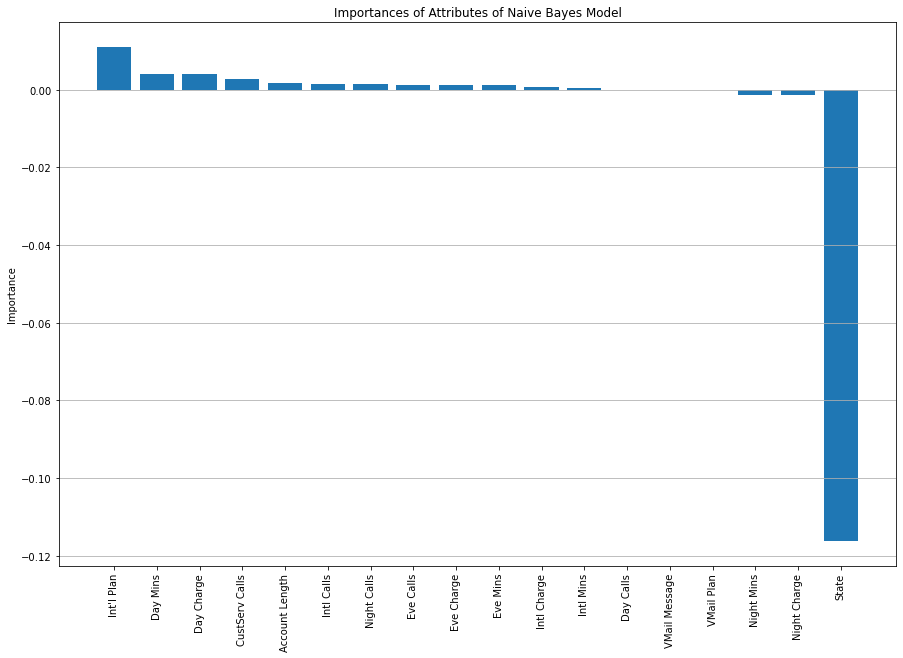

In [36]:
ind_nb,new_import_df_nb=get_importance(importance_nb)
plt.bar([x for x in range(len(new_import_df_nb))], new_import_df_nb[0])
plt.xticks([i for i in range(len(ind_nb))],ind_nb,rotation=90)
plt.ylabel('Importance')
plt.title('Importances of Attributes of Naive Bayes Model')
plt.grid(axis='y')
plt.show()

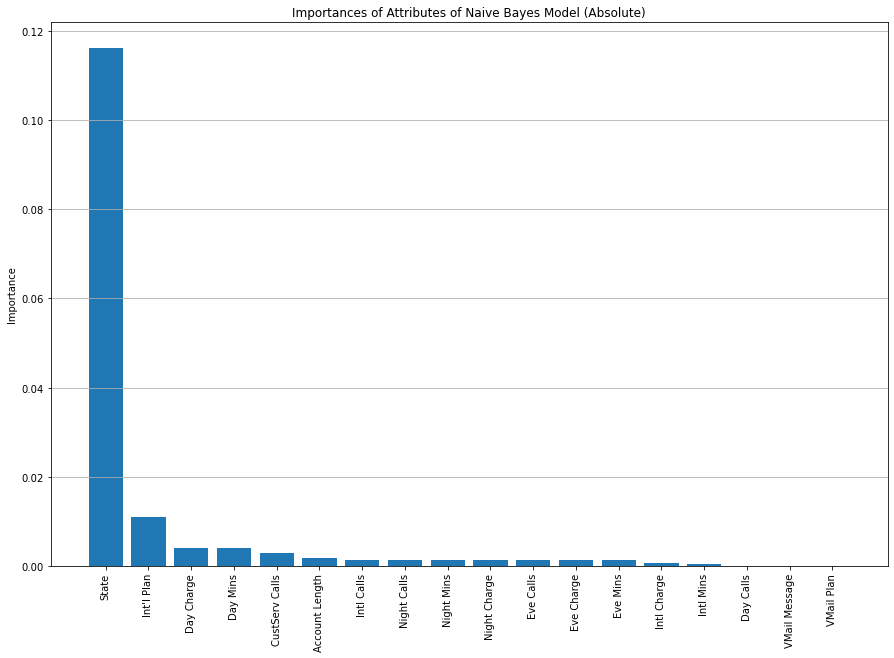

In [37]:
absolute_new_import_df_nb=abs(new_import_df_nb)
absolute_new_import_df_nb=absolute_new_import_df_nb.sort_values(by=0,ascending=False)
absolute_ind_nb=absolute_new_import_df_nb.index.tolist()
plt.bar([x for x in range(len(absolute_new_import_df_nb))], absolute_new_import_df_nb[0])
plt.xticks([i for i in range(len(absolute_ind_nb))],absolute_ind_nb,rotation=90)
plt.ylabel('Importance')
plt.title('Importances of Attributes of Naive Bayes Model (Absolute)')
plt.grid(axis='y')
plt.show()

# Confusion Matrix Comparison 

In [38]:
cm_compare=pd.DataFrame([[dt_tp,dt_fn,nb_tp,nb_fn],[dt_fp,dt_tn,nb_fp,nb_tn],[dt_accuracy,np.nan,nb_accuracy,np.nan],[dt_recall,np.nan,nb_recall,np.nan],[dt_precision,np.nan,nb_precision,np.nan]],
                        index=pd.Index(['Churn','Not Churn','Accuracy','Recall','Precision'],name='Actual:'),
                        columns=pd.MultiIndex.from_product([['Decision Tree','Naive Bayes'],['Churn','Not Churn']],names=['Model:','Predicted']))
cm_compare=cm_compare.style.format('{:.2f}')

In [39]:
cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': [('font-style','italic'), ('color', 'darkgrey'), ('font-weight','normal')]
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': [('background-color','#000066'), ('color','white')]
}


In [40]:
cm_compare=cm_compare.set_table_styles([cell_hover, index_names, headers])

In [41]:
cm_compare=cm_compare.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level0', 'props': [('font-size', '1.5em')]},
    {'selector': 'td', 'props': [('text-align','center'), ('font-weight', 'bold')]}
], overwrite=False)

In [42]:
cm_compare=cm_compare.set_table_styles({
    ('Naive Bayes', 'Churn'): [{'selector': 'th', 'props': [('border-left','1px solid white')]},
                               {'selector': 'td', 'props': [('border-left','1px solid #000066')]}]
}, overwrite=False, axis=0)

In [43]:
cm_compare

# Find which attributes to build models

### Decision Tree

In [44]:
def visual_metrics(model,import_df,arrow_one,arrow_two):
    train_accuracies=[]
    test_accuracies=[]
    train_precisions=[]
    test_precisions=[]
    use_cols=[]
    features=import_df.index.tolist()
    for i in range(len(features),0,-1):
        use_features=features[:i]
        use_cols.append(len(use_features))
        X=df[use_features]
        if 'State' in use_features:
            X=pd.get_dummies(X,columns=['State'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0)
        if model=='Decision Tree':
            classifier=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
        else:
            classifier=GaussianNB()
        classifier.fit(X_train,y_train)
        train_accuracies.append(accuracy_score(y_train,classifier.predict(X_train)))
        test_accuracies.append(accuracy_score(y_test,classifier.predict(X_test)))
        train_precisions.append(precision_score(y_train,classifier.predict(X_train)))
        test_precisions.append(precision_score(y_test,classifier.predict(X_test)))
    fig,(ax1,ax2)=plt.subplots(2)
    ax1.plot(use_cols,train_accuracies,'-o',label='Train')
    ax1.plot(use_cols,test_accuracies,'-o',label='Test')
    ax1.legend(loc='lower left')
    ax1.invert_xaxis()
    ax1_y_max=max(test_accuracies)
    ax1_x=use_cols[test_accuracies.index(ax1_y_max)]
    ax1.annotate('Highest Accuracy ({} features used)'.format(ax1_x),xy=(ax1_x,ax1_y_max),xytext=(ax1_x, ax1_y_max+arrow_one),arrowprops=dict(facecolor='black', shrink=0.05))
    ax1.set_title('Accuracy of {}'.format(model))
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(use_cols)
    ax1.grid(axis='x')
    
    ax2.plot(use_cols,train_precisions,'-o',label='Train')
    ax2.plot(use_cols,test_precisions,'-o',label='Test')
    ax2.legend(loc='lower left')
    ax2.invert_xaxis()
    ax2_y_max=max(test_precisions)
    ax2_x=use_cols[test_precisions.index(ax2_y_max)]
    ax2.annotate('Highest Precision ({} features used)'.format(ax2_x),xy=(ax2_x,ax2_y_max),xytext=(ax2_x, ax2_y_max+arrow_two),arrowprops=dict(facecolor='black', shrink=0.05))
    ax2.set_title('Precision of {}'.format(model))
    ax2.set_ylabel('Precision')
    ax2.set_xlabel('Top N important attributes')
    ax2.set_xticks(use_cols)
    ax2.grid(axis='x')
    fig.show()
    return ax1_x,ax2_x

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


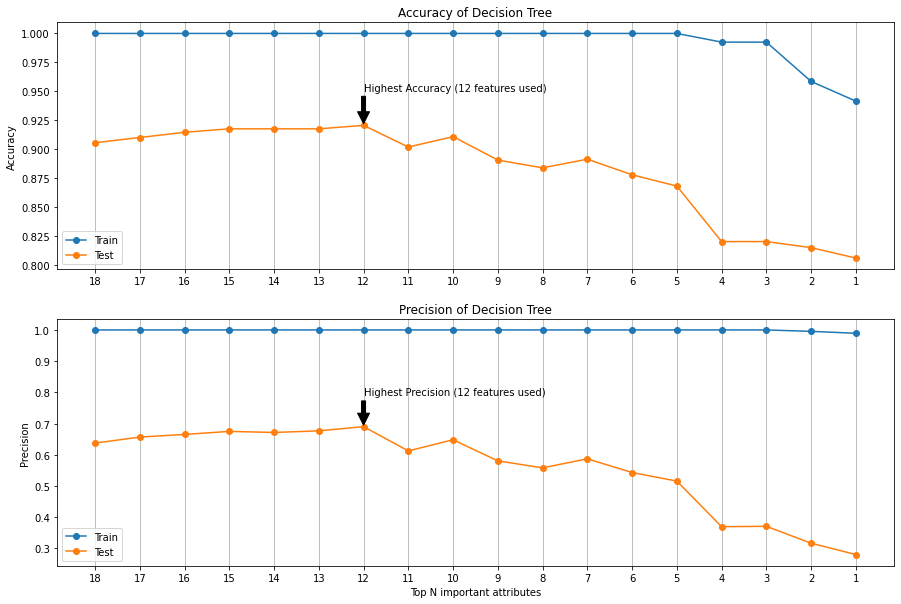

In [45]:
highest_accuracy_att_dt,highest_precision_att_dt=visual_metrics('Decision Tree',new_import_df_dt,0.03,0.1)

### Naive Bayes

In [46]:
import_nb=new_import_df_nb.apply(lambda x:abs(x))
import_nb=import_nb.sort_values(by=0,ascending=False)

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


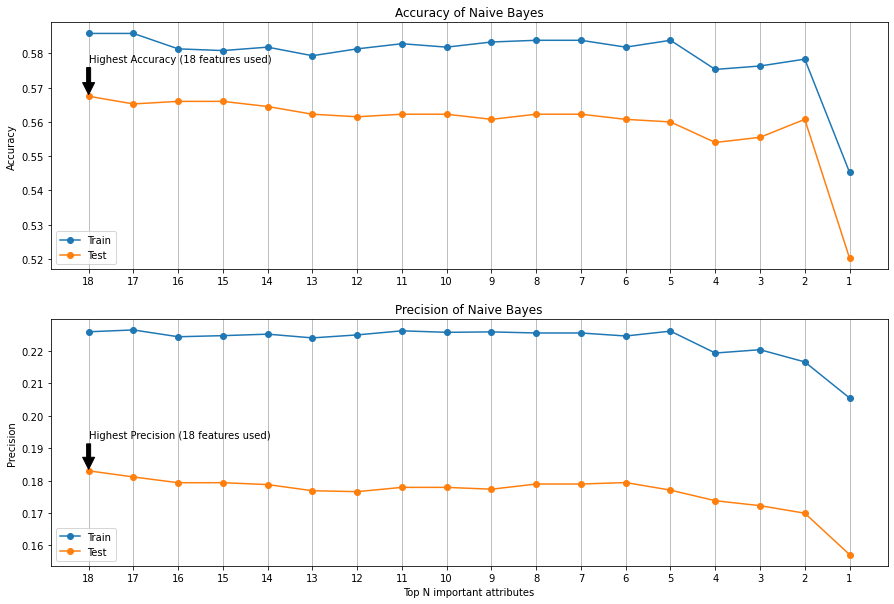

In [47]:
highest_accuracy_att_nb,highest_precision_att_nb=visual_metrics('Naive Bayes',import_nb,0.01,0.01)

# Building models using filtered attributes

### Decision Tree

In [48]:
filtered_att_dt=new_import_df_dt.index.tolist()[:highest_precision_att_dt]
print('Using the following attributes to build a new model:\n')
for i,att in enumerate(filtered_att_dt):
    print('{}. {}'.format(i+1,att))

Using the following attributes to build a new model:

1. Day Mins
2. Int'l Plan
3. CustServ Calls
4. Day Charge
5. Eve Mins
6. Intl Mins
7. Intl Calls
8. Night Mins
9. Night Charge
10. VMail Message
11. Eve Charge
12. Day Calls


In [49]:
def filtered_att_pred(model,filtered_att):
    X_filtered=df[filtered_att]
    if 'State' in X_filtered.columns:
        X_filtered=pd.get_dummies(X_filtered,columns=['State'])
    X_train_filtered,X_test_filtered,y_train_filtered,y_test_filtered=train_test_split(X_filtered,y,test_size=0.4,random_state=0)
    if model=='Decision Tree':
        filtered_class=DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    else:
        filtered_class=GaussianNB()
    filtered_class.fit(X_train_filtered,y_train_filtered)
    
    y_pred_filtered = filtered_class.predict(X_test_filtered)
    cm = confusion_matrix(y_test_filtered, y_pred_filtered)
    tn, fp, fn, tp= confusion_matrix(y_test_filtered, y_pred_filtered).ravel()
    print(cm)
    print(' ')
    print('True Positive is {}.'.format(tp))
    print('True Negative is {}.'.format(tn))
    print('False Positive is {}.'.format(fp))
    print('False Negative is {}.\n'.format(fn))
    accuracy=round(accuracy_score(y_test_filtered, y_pred_filtered),2)
    recall=round(recall_score(y_test_filtered, y_pred_filtered),2)
    precision=round(precision_score(y_test_filtered, y_pred_filtered),2)
    print('Accuracy is {}.'.format(accuracy))
    print('Recall is {}.'.format(recall))
    print('Precision is {}.\n'.format(precision))
    return tn,fp,fn,tp,accuracy,recall,precision

In [50]:
dt_tn_filtered,dt_fp_filtered,dt_fn_filtered,dt_tp_filtered,dt_accuracy_filtered,dt_recall_filtered,dt_precision_filtered=filtered_att_pred('Decision Tree',filtered_att_dt)

[[1090   62]
 [  44  138]]
 
True Positive is 138.
True Negative is 1090.
False Positive is 62.
False Negative is 44.

Accuracy is 0.92.
Recall is 0.76.
Precision is 0.69.



### Naive Bayes

In [51]:
filtered_att_nb=import_nb.index.tolist()[:highest_precision_att_nb]
print('Using the following attributes to build a new model:\n')
for i,att in enumerate(filtered_att_nb):
    print('{}. {}'.format(i+1,att))

Using the following attributes to build a new model:

1. State
2. Int'l Plan
3. Day Charge
4. Day Mins
5. CustServ Calls
6. Account Length
7. Intl Calls
8. Night Calls
9. Night Mins
10. Night Charge
11. Eve Calls
12. Eve Charge
13. Eve Mins
14. Intl Charge
15. Intl Mins
16. Day Calls
17. VMail Message
18. VMail Plan


In [52]:
nb_tn_filtered,nb_fp_filtered,nb_fn_filtered,nb_tp_filtered,nb_accuracy_filtered,nb_recall_filtered,nb_precision_filtered=filtered_att_pred('Naive Bayes',filtered_att_nb)

[[643 509]
 [ 68 114]]
 
True Positive is 114.
True Negative is 643.
False Positive is 509.
False Negative is 68.

Accuracy is 0.57.
Recall is 0.63.
Precision is 0.18.



# Confusion Matrix Comparison

In [53]:
cm_compare2=pd.DataFrame([[dt_tp,dt_fn,dt_tp_filtered,dt_fn_filtered,nb_tp,nb_fn,nb_tp_filtered,nb_fn_filtered],
                          [dt_fp,dt_tn,dt_fp_filtered,dt_tn_filtered,nb_fp,nb_tn,nb_fp_filtered,nb_tn_filtered],
                          [dt_accuracy,np.nan,dt_accuracy_filtered,np.nan,nb_accuracy,np.nan,nb_accuracy_filtered,np.nan],
                          [dt_recall,np.nan,dt_recall_filtered,np.nan,nb_recall,np.nan,nb_recall_filtered,np.nan],
                          [dt_precision,np.nan,dt_precision_filtered,np.nan,nb_precision,np.nan,nb_precision_filtered,np.nan]],
                        index=pd.Index(['Churn','Not Churn','Accuracy','Recall','Precision'],name='Actual:'),
                        columns=pd.MultiIndex.from_product([['Decision Tree','Decision Tree (filtered)','Naive Bayes','Naive Bayes (filtered)'],['Churn','Not Churn']],names=['Model:','Predicted']))
cm_compare2=cm_compare2.style.format('{:.2f}')

In [54]:
cm_compare2=cm_compare2.set_table_styles([cell_hover, index_names, headers])
cm_compare2=cm_compare2.set_table_styles([
    {'selector': 'th.col_heading', 'props': [('text-align', 'center')]},
    {'selector': 'th.col_heading.level0', 'props': [('font-size', '1.5em')]},
    {'selector': 'td', 'props': [('text-align','center'), ('font-weight', 'bold')]}
], overwrite=False)
cm_compare2=cm_compare2.set_table_styles({
    ('Naive Bayes', 'Churn'): [{'selector': 'th', 'props': [('border-left','1px solid white')]},
                               {'selector': 'td', 'props': [('border-left','1px solid #000066')]}]
}, overwrite=False, axis=0)

In [55]:
cm_compare2